In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import r2_score

In [2]:
# Load the dataset
data = pd.read_csv('colombo_rh_2012-2018.csv')

In [3]:
data

,station_id,station_name,element_name,year,month,day,obs_val
0,43466,COLOMBO,RHMAX,2012,1,1,91.0
1,43466,COLOMBO,RHMAX,2012,1,2,90.0
2,43466,COLOMBO,RHMAX,2012,1,3,89.0
3,43466,COLOMBO,RHMAX,2012,1,4,89.0
4,43466,COLOMBO,RHMAX,2012,1,5,95.0
...,...,...,...,...,...,...,...
4398,43466,COLOMBO,RHMAX,2018,12,27,90.0
4399,43466,COLOMBO,RHMAX,2018,12,28,88.0
4400,43466,COLOMBO,RHMAX,2018,12,29,76.0
4401,43466,COLOMBO,RHMAX,2018,12,30,81.0


In [4]:
print(data.head())
print(data.describe())

   station_id station_name element_name  year  month  day  obs_val
0       43466      COLOMBO        RHMAX  2012      1    1     91.0
1       43466      COLOMBO        RHMAX  2012      1    2     90.0
2       43466      COLOMBO        RHMAX  2012      1    3     89.0
3       43466      COLOMBO        RHMAX  2012      1    4     89.0
4       43466      COLOMBO        RHMAX  2012      1    5     95.0
       station_id         year        month          day      obs_val
count      4403.0  4403.000000  4403.000000  4403.000000  4383.000000
mean      43466.0  2015.736998     6.517375    15.797411    82.619895
std           0.0     1.925666     3.449889     8.838334     8.533591
min       43466.0  2012.000000     1.000000     1.000000    46.000000
25%       43466.0  2014.000000     4.000000     8.000000    77.000000
50%       43466.0  2016.000000     7.000000    16.000000    84.000000
75%       43466.0  2017.000000    10.000000    23.000000    89.000000
max       43466.0  2018.000000    12.0

In [5]:
# Convert the date columns to datetime format
#data['date'] = pd.to_datetime(data[['year', 'month', 'day']], errors='coerce' , inplace =True)
date_cols = ['year', 'month', 'day']
data['date'] = pd.to_datetime(data[date_cols], errors='coerce' )


# Drop rows with missing date values
data.dropna(subset=['date'], inplace=True)

# Set the date column as the index
data.set_index('date', inplace=True)

In [6]:
data

,station_id,station_name,element_name,year,month,day,obs_val
date,,,,,,,
2012-01-01,43466,COLOMBO,RHMAX,2012,1,1,91.0
2012-01-02,43466,COLOMBO,RHMAX,2012,1,2,90.0
2012-01-03,43466,COLOMBO,RHMAX,2012,1,3,89.0
2012-01-04,43466,COLOMBO,RHMAX,2012,1,4,89.0
2012-01-05,43466,COLOMBO,RHMAX,2012,1,5,95.0
...,...,...,...,...,...,...,...
2018-12-27,43466,COLOMBO,RHMAX,2018,12,27,90.0
2018-12-28,43466,COLOMBO,RHMAX,2018,12,28,88.0
2018-12-29,43466,COLOMBO,RHMAX,2018,12,29,76.0


In [7]:
#Remove unwanted columns
data_preprocessed = data.drop(['station_id', 'station_name', 'element_name' ,'year','month','day'], axis=1)


In [8]:
data_preprocessed

,obs_val
date,
2012-01-01,91.0
2012-01-02,90.0
2012-01-03,89.0
2012-01-04,89.0
2012-01-05,95.0
...,...
2018-12-27,90.0
2018-12-28,88.0
2018-12-29,76.0


In [9]:
# get the Nan values
data_preprocessed.isnull().sum()

obs_val    0
dtype: int64

<AxesSubplot:xlabel='date'>

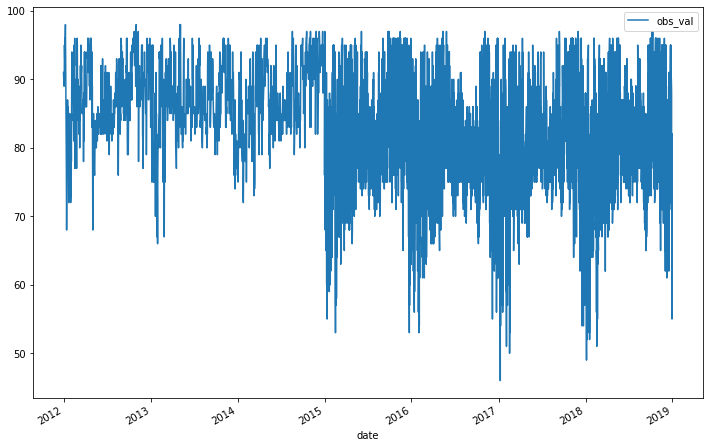

In [10]:
# plot the preprocessed data
data_preprocessed.plot(figsize=(12,8))

<AxesSubplot:xlabel='date'>

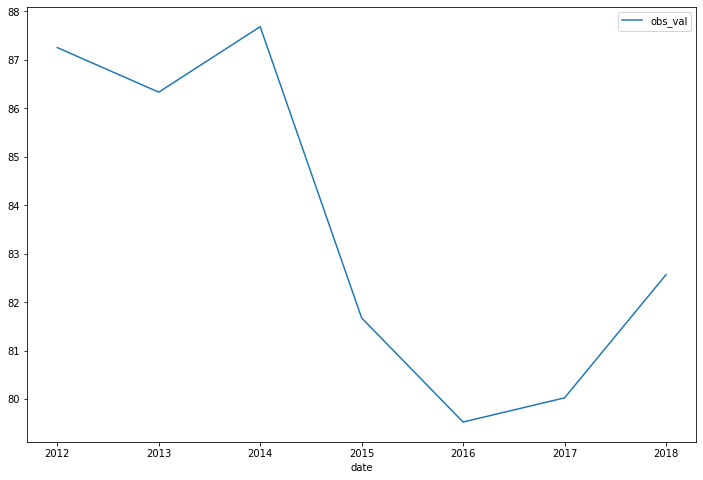

In [11]:
# plot the line of average temperature for each year
data_preprocessed.groupby(data_preprocessed.index.year).mean().plot(figsize=(12,8))

In [ ]:
# data_preprocessed1 =data_preprocessed.diff().fillna(data_preprocessed)
# pyplot.plot(data_preprocessed1)
# pyplot.show()

In [ ]:
# data_preprocessed2=data_preprocessed1.diff().fillna(data_preprocessed1)
# pyplot.plot(data_preprocessed2)
# pyplot.show()

In [12]:
# After considering the data, we will take last seven decades of data for training and test the model
# get the data from 1950

#newdata = data_preprocessed[data_preprocessed.index.year >= 2012]
traindata = data_preprocessed[:-365]
testdata = data_preprocessed[-365:]


In [13]:
def test_stationarity_timeseries(timeseries):
        #Determing rolling statistics
        rolmean = timeseries.rolling(window=12).mean()
        rolstd = timeseries.rolling(window=12).std()
    
        #Plot rolling statistics:
        orig = plt.plot(timeseries, color='blue',label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)
        
        #Perform Dickey-Fuller test:
        print('Results of Dickey-Fuller Test:')
        df_test = adfuller(timeseries, autolag='AIC')
        df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in df_test[4].items():
            df_output['Critical Value (%s)'%key] = value

        print(df_output)


        #Assess the stationarity of the time series according to the Dickey-Fuller test
        if df_output['p-value'] > 0.05:
            print('The series is likely non-stationary')
        else:
            print('The series is likely stationary')

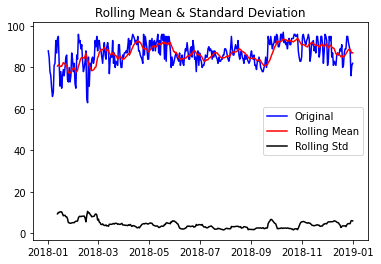

Results of Dickey-Fuller Test:
Test Statistic                  -5.393155
p-value                          0.000004
#Lags Used                       4.000000
Number of Observations Used    360.000000
Critical Value (1%)             -3.448646
Critical Value (5%)             -2.869602
Critical Value (10%)            -2.571065
dtype: float64
The series is likely stationary


In [14]:
# Test stationarity
test_stationarity_timeseries(testdata['obs_val'])

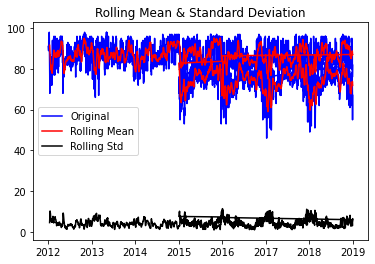

Results of Dickey-Fuller Test:
Test Statistic                   -3.661287
p-value                           0.004692
#Lags Used                       27.000000
Number of Observations Used    3990.000000
Critical Value (1%)              -3.431990
Critical Value (5%)              -2.862265
Critical Value (10%)             -2.567156
dtype: float64
The series is likely stationary


In [15]:
# Test stationarity
test_stationarity_timeseries(traindata['obs_val'])

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='obs_val'>

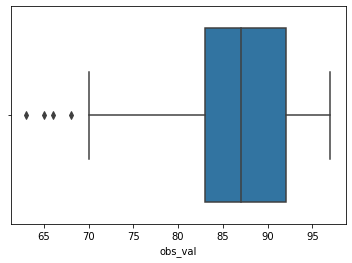

In [16]:
# boxplot
sns.boxplot(testdata['obs_val'])

In [45]:
#train the model with auto_arima
model = auto_arima(traindata['obs_val'], start_p=1, start_q=1, 
                      max_p=3, max_q=3, m=12,                         
                        start_P=0, seasonal=True,
                          d=1, D=1, trace=True, error_action='ignore',
                            suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.42 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=27087.607, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=25618.506, Time=0.49 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.42 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=26765.416, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=25166.635, Time=1.29 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=10.66 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=3.02 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=25482.047, Time=0.85 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=25060.101, Time=1.53 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=25499.073, Time=0.75 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=12.04 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=4.77 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=24964.308, Time=1.74 sec
 ARIMA(3,1,0)(1,1,0)[12]             : 

In [18]:
from statsmodels.tsa.arima.model import ARIMA

# Fit the ARIMA model to the traindata
model = ARIMA(traindata['obs_val'], order=(3, 1, 0), seasonal_order=(2, 1, 0, 12))
fitted_model = model.fit()

c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monoto

In [19]:
# Add the predictions to the testdata DataFrame
# test the model with the test data
predict = fitted_model.predict(n_periods=365 , freq='D')

In [20]:
predict

date
2012-01-01     0.000000
2012-01-02    90.999370
2012-01-03    89.999842
2012-01-04    88.999855
2012-01-05    89.000192
                ...    
2018-12-27    76.644246
2018-12-28    76.865698
2018-12-29    72.526247
2018-12-30    69.373747
2018-12-31    59.444499
Name: predicted_mean, Length: 4018, dtype: float64

In [37]:

# Create a date range from 2019-01-01 to 2024-03-01
date_range = pd.date_range(start='2019-01-01', end='2024-03-01', freq='MS')

# Generate predictions for the entire date range
forecast = fitted_model.forecast(steps=len(date_range))

# Create a dataframe to store the predictions
predictions = pd.DataFrame({'Date': date_range, 'Forecast': forecast})

# Set the 'Date' column as the index
predictions.set_index('Date', inplace=True)


c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [38]:
predictions

,Forecast
Date,
2019-01-01,64.270836
2019-02-01,67.285591
2019-03-01,70.621459
2019-04-01,67.482830
2019-05-01,67.976711
...,...
2023-11-01,48.723997
2023-12-01,54.180106
2024-01-01,51.512566


In [40]:
predictions.to_csv('forecast.csv')

<AxesSubplot:xlabel='date'>

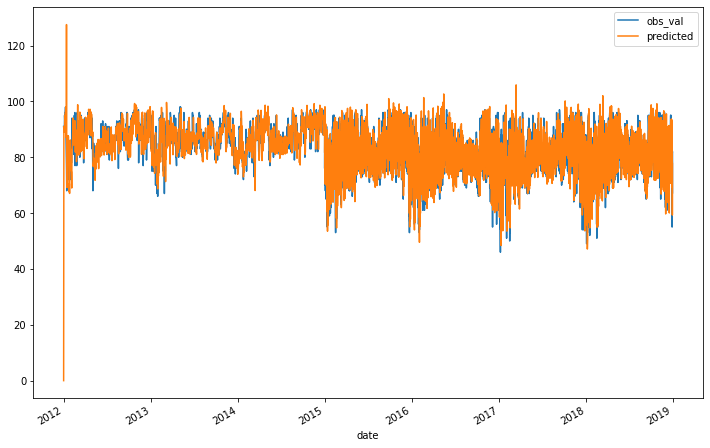

In [23]:
# plot the actual vs predicted values
data_preprocessed[['obs_val', 'predicted']].plot(figsize=(12,8))